This file generates plots for fairness metrics in machine learning models trained with Stochastic Ghost. It provides a convenient tool for visualizing various fairness measures, such as disparate impact, equal opportunity, and predictive parity or anything specific according to the use case, to assess the performance and fairness of models across different demographic groups.

In [123]:
import os
from sklearn.metrics import roc_curve, auc, log_loss
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import importlib 
import ipywidgets as widgets
from ipywidgets import interactive, FloatSlider, Button, Output, VBox

Select and load dataset

In [168]:
def handle_dataset_selection(change):
    global DATASET
    DATASET = change.new

# Create dropdown widget
dropdown = widgets.Dropdown(
    options=['Select Dataset', 'income', 'compas'],
    description='Dataset:',
    disabled=False
)

# Assign the handler function to the dropdown's observe method
dropdown.observe(handle_dataset_selection, 'value')

# Display the dropdown
display(dropdown)

Dropdown(description='Dataset:', options=('Select Dataset', 'income', 'compas'), value='Select Dataset')

In [212]:
#DATASET = 'income'
#DATASET = 'compas'

# Can select out of 2 models currently : 1) pytorch 2) tensorflow

# MODEL = "tensorflow_connect"
# MODEL_NAME = "../tensorflow_connect"
MODEL = "pytorch_connect"
MODEL_NAME = "../pytorch_connect"
DIRECTORY_PATH = "../saved_models/" + DATASET + '/' + MODEL 

In [213]:
if MODEL_NAME.endswith("pytorch_connect"):
    FILE_EXT = '.pt'
elif MODEL_NAME.endswith("tensorflow_connect"):
    FILE_EXT = '.h5'

In [214]:
import sys
sys.path.append('..')

from humancompatible.train.pytorch_connect import load_model

## For tensorflow model :
## from tensorflow_connect import load_model

In [217]:
if DATASET=='income':
    DATASET = 'income'
    CSV_FILE = 'adult.data'
    SENS_IND = 2
    SENSITIVE_CODE_0 = 0
    SENSITIVE_CODE_1 = 1
    sensitive_value_0 = "male"
    sensitive_value_1 = "female"
    category_0 = "<=50K"
    category_1 = ">50K"
    sensitive_col_name = "gender_code"
    sensitive = "gender"
    in_columns = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
    out_columns = ['education_code', 'marital_code', 'gender_code', 'occupation_code', 'relationship_code', 'race_code', 'country_code', 'hours_code']

elif DATASET=='compas':
    DATASET = 'compas'
    CSV_FILE = 'compas-scores-two-years.csv'
    SENS_IND = 4
    SENSITIVE_CODE_0 = 0
    SENSITIVE_CODE_1 = 1
    sensitive_value_0 = "white"
    sensitive_value_1 = "black"
    category_0 = "TL=0"
    category_1 = "TL=1"
    sensitive_col_name = "race_code"
    sensitive = "race"
    in_columns = ['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid']
    out_columns = ['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code']

elif DATASET=='hiring':
    DATASET = 'compas'
    CSV_FILE = 'recruitmentdataset-2022-1.3.csv'
    SENS_IND = 0
    SENSITIVE_CODE_0 = 0
    SENSITIVE_CODE_1 = 1
    sensitive_value_0 = "male"
    sensitive_value_1 = "female"
    DIRECTORY_PATH = "hiring_models"
    category_0 = "TL=0"
    category_1 = "TL=1"
    sensitive_col_name = "gender_code"
    sensitive = "gender"
    in_columns = ['Id','gender','age','nationality','sport','university_grade','debateclub','programming_exp','international_exp','entrepeneur_exp','languages','exact_study','degree','company','decision']
    out_columns = ['gender_code', 'debate_code', 'programming_code', 'international_code', 'entrepeneur_code', 'study_code', 'nationality_code', 'sport_code', 'degree_code', 'company_code', 'age_code']

In [220]:
column_names = in_columns
in_df = pd.read_csv(os.path.join("../data",CSV_FILE), names=column_names)

In [221]:
#column_names = ['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid']
#in_df = pd.read_csv('compas-scores-two-years.csv', names=column_names)

#### Load saved models

In [255]:
# Define the directory path where your models are saved
directory_path = DIRECTORY_PATH

# List all the files in the directory
file_list = os.listdir(directory_path)


# Filter files to select only model files (e.g., with '.pt' extension)
model_files = [file for file in file_list if DATASET in file and file.endswith(FILE_EXT)]

# Create an empty dictionary to store loaded models
loaded_models = []

# Load each model and store it in the dictionary
for model_file in model_files:
    # Extract model name from the file name
    model_name = model_file.split('.')[0]
    
    # Load the model
    model_load = load_model(directory_path, model_file)
    
    # Add the loaded model to the dictionary
    loaded_models.append((model_file, model_load))

# Now you can access each model using its name as the key in the loaded_models dictionary
# For example, to access the model named "model1", you can do:
# loaded_models["model1"]

In [223]:
df_raw = pd.read_csv('../data/val_data/val_data_raw_'+str(DATASET)+'.csv')
df_scaled = pd.read_csv('../data/val_data/val_data_scaled_'+str(DATASET)+'.csv')

In [224]:
x_raw = df_raw.values[:,:-1]
x_scaled = df_scaled.values[:,:-1]
y = df_scaled.values[:,-1]

In [225]:
def get_auc(predictions, targets):
    predictions = predictions.detach().numpy()
    targets = targets

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr, thresholds 

#### Evaluate model metrics on the validation dataset

In [ ]:
results_list = []

# results_df_pr = pd.DataFrame(columns=['Model', 'AUC_Sensitive_0', 'AUC_Sensitive_1', 'Optimal_Threshold_0', 'Optimal_Threshold_1'])

# Iterate over all models
for model_index, model_iter in enumerate(loaded_models):
    # Set the model to evaluation mode
    (model_name, model) = model_iter
    model.eval()

    # Forward pass for subgroup with sensitive attribute A=0
    predictions_0 = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))
    predictions_1 = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

    acc_0 = np.sum(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)] == (predictions_0[:,0] > 0.5)) / len(predictions_0)
    acc_1 = np.sum(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)] == (predictions_1[:,0] > 0.5)) / len(predictions_1)
    l_0 = log_loss(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], predictions_0[:,0])
    l_1 = log_loss(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], predictions_1[:,0])
    # Calculate AUCs for sensitive attribute 0
    fpr_0, tpr_0, thresholds_0 = roc_curve(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], predictions_0)
    auc_0 = auc(fpr_0, tpr_0)

    # Calculate AUCs for sensitive attribute 1
    fpr_1, tpr_1, thresholds_1 = roc_curve(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], predictions_1)
    auc_1 = auc(fpr_1, tpr_1)

    auc_hm = (auc_0*auc_1)/(auc_0 + auc_1)

    # Calculate TPR-FPR difference for sensitive attribute 0
    tpr_minus_fpr_0 = tpr_0 - fpr_0
    optimal_threshold_index_0 = np.argmax(tpr_minus_fpr_0)
    optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

    # Calculate TPR-FPR difference for sensitive attribute 1
    tpr_minus_fpr_1 = tpr_1 - fpr_1
    optimal_threshold_index_1 = np.argmax(tpr_minus_fpr_1)
    optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]

    # Store results in the DataFrame
    results_list.append({'Model': str(model_name),
                                    'AUC_Sensitive_0': auc_0,
                                    'AUC_Sensitive_1': auc_1,
                                    'AUC_HM' : auc_hm,
                                    'Accuracy_0': acc_0,
                                    'Accuracy_1': acc_1,
                                    'Loss_0': l_0,
                                    'Loss_1': l_1,
                                    # 'Optimal_Threshold_0': optimal_threshold_0,
                                    # 'Optimal_Threshold_1': optimal_threshold_1
                                    })
    
res_df = pd.DataFrame(results_list)

res_df

,Model,AUC_Sensitive_0,AUC_Sensitive_1,AUC_HM,Accuracy_0,Accuracy_1,Loss_0,Loss_1
0,net_al_compas_lb0.01_s1_tr0.pt,0.645404,0.704567,0.336845,0.626911,0.598925,0.680223,0.679389
1,net_al_compas_lb0.01_s1_tr1.pt,0.654673,0.678248,0.333126,0.634557,0.624731,0.669000,0.666411
2,net_al_compas_lb0.01_s1_tr2.pt,0.670201,0.682581,0.338167,0.648318,0.620430,0.675246,0.677759
3,net_al_compas_lb0.01_s1_tr3.pt,0.655907,0.698400,0.338244,0.648318,0.617204,0.670304,0.670351
4,net_al_compas_lb0.01_s1_tr4.pt,0.661613,0.669248,0.332704,0.643731,0.636559,0.673838,0.675767
5,net_al_compas_lb0.01_sexp_tr0.pt,0.606156,0.686512,0.321918,0.648318,0.617204,0.671581,0.671736
6,net_al_compas_lb0.01_sexp_tr1.pt,0.649046,0.644289,0.323330,0.626911,0.584946,0.682977,0.685220
7,net_al_compas_lb0.01_sexp_tr2.pt,0.615938,0.715590,0.331018,0.623853,0.669892,0.675018,0.663657
8,net_al_compas_lb0.01_sexp_tr3.pt,0.614349,0.705484,0.328385,0.665138,0.663441,0.678408,0.680084
9,net_al_compas_lb0.01_sexp_tr4.pt,0.607478,0.686530,0.322295,0.663609,0.622581,0.668640,0.668996


Sort by difference in loss between protected classes:

In [262]:
res_df['loss_abs_diff'] = abs(res_df.Loss_0 - res_df.Loss_1)
res_df.sort_values(by='loss_abs_diff', ascending=True)

,Model,AUC_Sensitive_0,AUC_Sensitive_1,AUC_HM,Accuracy_0,Accuracy_1,Loss_0,Loss_1,loss_abs_diff
3,net_al_compas_lb0.01_s1_tr3.pt,0.655907,0.698400,0.338244,0.648318,0.617204,0.670304,0.670351,0.000047
5,net_al_compas_lb0.01_sexp_tr0.pt,0.606156,0.686512,0.321918,0.648318,0.617204,0.671581,0.671736,0.000156
9,net_al_compas_lb0.01_sexp_tr4.pt,0.607478,0.686530,0.322295,0.663609,0.622581,0.668640,0.668996,0.000356
0,net_al_compas_lb0.01_s1_tr0.pt,0.645404,0.704567,0.336845,0.626911,0.598925,0.680223,0.679389,0.000834
12,net_ghost_compas_lb0.01_tr1.pt,0.559494,0.550965,0.277598,0.603976,0.511828,0.688975,0.690455,0.001480
15,net_ghost_compas_lb0.01_tr4.pt,0.487572,0.492613,0.245040,0.500000,0.466667,0.705113,0.703606,0.001507
8,net_al_compas_lb0.01_sexp_tr3.pt,0.614349,0.705484,0.328385,0.665138,0.663441,0.678408,0.680084,0.001677
4,net_al_compas_lb0.01_s1_tr4.pt,0.661613,0.669248,0.332704,0.643731,0.636559,0.673838,0.675767,0.001929
6,net_al_compas_lb0.01_sexp_tr1.pt,0.649046,0.644289,0.323330,0.626911,0.584946,0.682977,0.685220,0.002242
2,net_al_compas_lb0.01_s1_tr2.pt,0.670201,0.682581,0.338167,0.648318,0.620430,0.675246,0.677759,0.002513


Alternatively, sort by AUC

Area under the Curve b/w the TPR and FPR is used here to select the best model TNR and FNR could equivalently be used as well, We need the AUCs for Sensitive value = 0 and Sensitive value = 1 to be as close as possible, Important point to note here is decision threshold as well, closer the decision threshold better it is to make a fair boundary. Harmonic mean of these is a good selection criteria. Otherwise, a better criteria could be disparate impact which ensures predictive parity across all rates

In [ ]:
res_df.sort_values(by='AUC_HM', ascending=False)

,Model,AUC_Sensitive_0,AUC_Sensitive_1,AUC_HM,Accuracy_0,Accuracy_1,Loss_0,Loss_1,loss_abs_diff
3,net_al_compas_lb0.01_s1_tr3.pt,0.655907,0.698400,0.338244,0.648318,0.617204,0.670304,0.670351,0.000047
2,net_al_compas_lb0.01_s1_tr2.pt,0.670201,0.682581,0.338167,0.648318,0.620430,0.675246,0.677759,0.002513
0,net_al_compas_lb0.01_s1_tr0.pt,0.645404,0.704567,0.336845,0.626911,0.598925,0.680223,0.679389,0.000834
1,net_al_compas_lb0.01_s1_tr1.pt,0.654673,0.678248,0.333126,0.634557,0.624731,0.669000,0.666411,0.002588
4,net_al_compas_lb0.01_s1_tr4.pt,0.661613,0.669248,0.332704,0.643731,0.636559,0.673838,0.675767,0.001929
7,net_al_compas_lb0.01_sexp_tr2.pt,0.615938,0.715590,0.331018,0.623853,0.669892,0.675018,0.663657,0.011360
8,net_al_compas_lb0.01_sexp_tr3.pt,0.614349,0.705484,0.328385,0.665138,0.663441,0.678408,0.680084,0.001677
6,net_al_compas_lb0.01_sexp_tr1.pt,0.649046,0.644289,0.323330,0.626911,0.584946,0.682977,0.685220,0.002242
9,net_al_compas_lb0.01_sexp_tr4.pt,0.607478,0.686530,0.322295,0.663609,0.622581,0.668640,0.668996,0.000356
5,net_al_compas_lb0.01_sexp_tr0.pt,0.606156,0.686512,0.321918,0.648318,0.617204,0.671581,0.671736,0.000156


Run the below cell if you want a list of models along with performance metrics for TNR, FNR (negative rates) 
Used in the case where you want to select a model based on AUC under TNR-FNR curce

In [231]:
results_list_nr = []

# results_df_nr = pd.DataFrame(columns=['Model', 'AUC_Sensitive_0', 'AUC_Sensitive_1', 'Optimal_Threshold_0', 'Optimal_Threshold_1', 'AUC_HM'])

# Iterate over all models
for model_index, model_iter in enumerate(loaded_models):
    # Set the model to evaluation mode
    (model_name, model) = model_iter
    model.eval()

    # Forward pass for subgroup with sensitive attribute A=0
    predictions_0 = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))

    # Forward pass for subgroup with sensitive attribute A=1
    predictions_1 = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

    # Calculate AUCs for sensitive attribute 0 
    fpr_0, tpr_0, thresholds_0 = roc_curve(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], predictions_0)
    auc_0 = auc(1-fpr_0, 1-tpr_0)  # AUC for FNR is calculated using TPR as x-axis and 1-FPR as y-axis
    tnr_minus_fnr_0 = (1-fpr_0) - (1-tpr_0)
    optimal_threshold_index_0 = np.argmax(tnr_minus_fnr_0)
    optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

    # Calculate AUCs for sensitive attribute 1 
    fpr_1, tpr_1, thresholds_1 = roc_curve(y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], predictions_1)
    auc_1 = auc(1-fpr_1, 1-tpr_1)  # AUC for TNR is calculated using 1-FPR as x-axis and TPR as y-axis
    tnr_minus_fnr_1 = (1-fpr_1) - (1-tpr_1)
    optimal_threshold_index_1 = np.argmax(tnr_minus_fnr_1)
    optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]

    # Find the threshold that maximizes TPR - FPR difference
    

    auc_hm = (auc_0*auc_1)/(auc_0+auc_1)

    results_list_nr.append({'Model': str(model_name),
                                          'AUC_Sensitive_0': auc_0,
                                          'AUC_Sensitive_1': auc_1,
                                          'Optimal_Threshold_0': optimal_threshold_0,
                                          'Optimal_Threshold_1': optimal_threshold_1,
                                          'AUC_HM': auc_hm
                                          })
    
results_df_nr = pd.DataFrame(results_list_nr)

In [232]:
results_df_nr.sort_values(by='AUC_HM', ascending=False)

,Model,AUC_Sensitive_0,AUC_Sensitive_1,Optimal_Threshold_0,Optimal_Threshold_1,AUC_HM
15,net_ghost_compas_lb0.01_tr4.pt,0.512428,0.507387,0.526083,0.471380,0.254947
14,net_ghost_compas_lb0.01_tr3.pt,0.574143,0.400623,0.462524,0.436236,0.235969
13,net_ghost_compas_lb0.01_tr2.pt,0.450752,0.472826,0.399642,0.379350,0.230763
12,net_ghost_compas_lb0.01_tr1.pt,0.440506,0.449035,0.502403,0.510705,0.222365
11,net_ghost_compas_lb0.01_tr0.pt,0.502172,0.384308,0.555146,0.574624,0.217702
10,net_al_compas_uncon.pt,0.500000,0.379398,inf,0.999879,0.215715
6,net_al_compas_lb0.01_sexp_tr1.pt,0.350954,0.355711,0.485023,0.511434,0.176658
5,net_al_compas_lb0.01_sexp_tr0.pt,0.393844,0.313488,0.499297,0.485793,0.174551
9,net_al_compas_lb0.01_sexp_tr4.pt,0.392522,0.313470,0.504903,0.477601,0.174285
4,net_al_compas_lb0.01_s1_tr4.pt,0.338387,0.330752,0.484932,0.500886,0.167263


Plotting the ROC between TPRs and FPRs (Selecting the best model out of the model list generated for the positive rates )

(654, 7)
(930, 7)


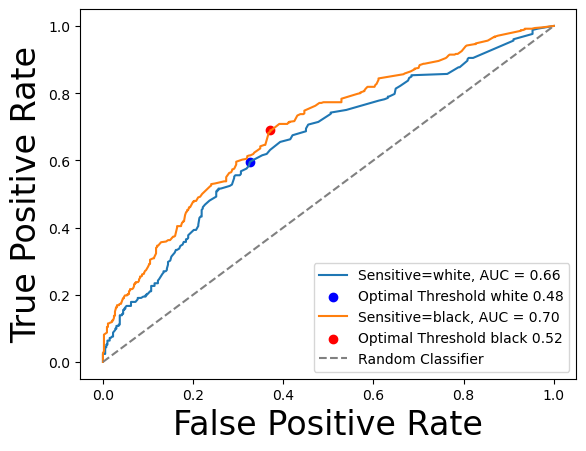

In [233]:
from sklearn.metrics import roc_curve, auc

# Load the best trail/trials
# For compas : model[6]
# For income : model[8]
#(model_name,model) = loaded_models[6]

model_idx = 3

(model_name,model) = loaded_models[model_idx]

# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tpr_minus_fpr = tpr - fpr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    
    # Plot the optimal threshold point on the ROC curve
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='blue' if sensitive_value == sensitive_value_0 else 'red', label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')


# Set your model to evaluation mode
model.eval()

# Forward pass for subgroup with sensitive attribute A=0
print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :].shape)
predictions_0 = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))

# Forward pass for subgroup with sensitive attribute A=1
print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :].shape)
predictions_1 = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

# Plot ROC for sensitive attribute A=0
plot_roc_curve_pr(predictions_0, y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], sensitive_value=sensitive_value_0)

# Plot ROC for sensitive attribute A=1
plot_roc_curve_pr(predictions_1, y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], sensitive_value=sensitive_value_1)

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
#plt.title('ROC Curve')
plt.legend()
plt.show()

Plotting the ROC between TNRs and FNRs

(654, 7)
(930, 7)
0.3440930269288478
0.301599537037037


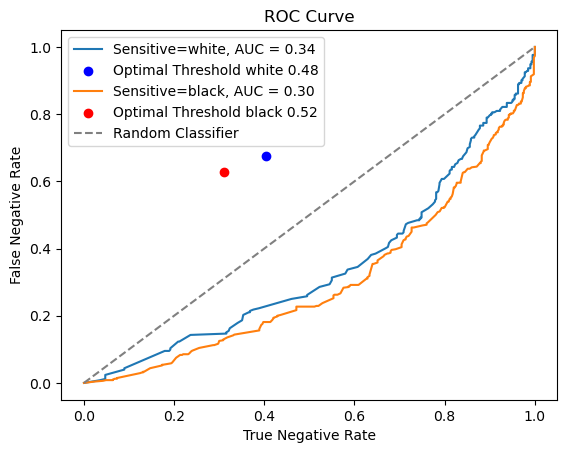

In [234]:
from sklearn.metrics import roc_curve, auc

# Load the best trail/trials
(model_name,model) = loaded_models[model_idx]


# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = (1-tpr)
    tnr = (1-fpr)
    roc_auc = auc(tnr, fnr)

    print(roc_auc)

    # Plot ROC curve
    plt.plot(tnr, fnr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    plt.scatter(fnr[optimal_threshold_index], tnr[optimal_threshold_index], c='blue' if sensitive_value == sensitive_value_0 else 'red', label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    # Plot the optimal threshold point on the ROC curve
    # if sensitive_value==sensitive_value_1:
    #     plt.scatter(tnr[optimal_threshold_index], fnr[optimal_threshold_index], c='red', marker='o', label=f'Optimal Threshold female = {optimal_threshold:.2f}')
    # if sensitive_value==sensitive_value_0:
    #     plt.scatter(tnr[optimal_threshold_index], fnr[optimal_threshold_index], c='blue', marker='o', label=f'Optimal Threshold male = {optimal_threshold:.2f}')

# Set your model to evaluation mode
model.eval()

# Forward pass for subgroup with sensitive attribute A=0
print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :].shape)
predictions_0 = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))

# Forward pass for subgroup with sensitive attribute A=1
print(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :].shape)
predictions_1 = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

# Plot ROC for sensitive attribute A=0
plot_roc_curve_nr(predictions_0, y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0)], sensitive_value=sensitive_value_0)

# Plot ROC for sensitive attribute A=1
plot_roc_curve_nr(predictions_1, y[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1)], sensitive_value=sensitive_value_1)

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Customize the plot
plt.xlabel('True Negative Rate')
plt.ylabel('False Negative Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Level 2 : Could select or reject a model based on the Predicted label distribution conditioned on Sensitive attribute value.

If the distribution of predicted labels conditioned on Sensitive attributes has a high overlap(low KL divergence) that means the model predictions are insensitive to the protected class value. This distribution also helps select the decision boundary for making final predictions.

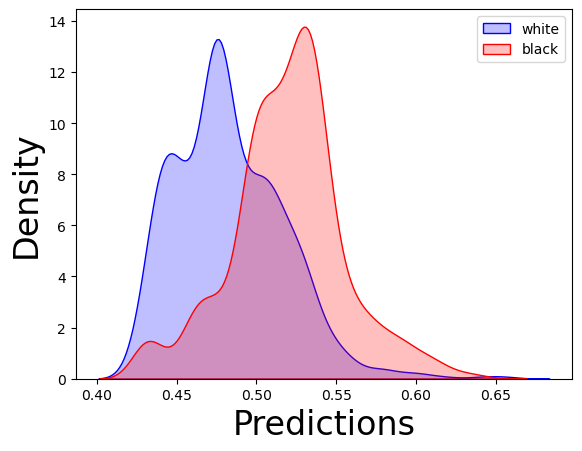

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt

# For compas : model[6]
# For income : model[8]
#(model_name,model) = loaded_models[6]

# model_idx = 

(model_name,model) = loaded_models[model_idx]

# Assuming you have predictions for male and female
predictions_0_tensor = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))
predictions_1_tensor = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))

# Convert predictions tensors to numpy arrays
predictions_0 = predictions_0_tensor
predictions_1 = predictions_1_tensor

# Create density distribution plot
sns.kdeplot(predictions_0.squeeze(), label=sensitive_value_0, color='blue', fill=True)
sns.kdeplot(predictions_1.squeeze(), label=sensitive_value_1, color='red', fill=True)

# Add labels and title
plt.xlabel('Predictions', fontsize=24)
plt.ylabel('Density', fontsize=24)
#plt.title('Density Distribution conditioned on Sensitive attribute')

# Show legend
plt.legend()

# Show plot
plt.show()

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pandas as pd

# Define function to calculate metrics based on threshold
def calculate_metrics(threshold):
    #acc_values = []

    # Calculate predictions for both sensitive values
    predictions_0_tensor = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))
    predictions_1_tensor = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))
    
    # Convert predictions tensors to numpy arrays
    predictions_0 = predictions_0_tensor
    predictions_1 = predictions_1_tensor
    
    
    outputs = model.evaluate(model.to_backend(x_scaled))
    predictions = (outputs >= threshold)

    true = y

    df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
    df_out["pred_labels"] = np.array(predictions).astype(int)
    df_out["true_labels"] = np.array(true).astype(int)

    acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]]) / len(df_out)
    #acc_values.append(acc)

    # True Positives, False Positives, True Negatives, False Negatives
    # True Positives, False Positives, True Negatives, False Negatives
    tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
    fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

    tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
    fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

    # Additional calculations
    fpr_sensitive_1 = fp_sensitive_1 / (fp_sensitive_1 + tn_sensitive_1) 
    tpr_sensitive_1 = tp_sensitive_1 / (tp_sensitive_1 + fn_sensitive_1) 
    fpr_sensitive_0 = fp_sensitive_0 / (fp_sensitive_0 + tn_sensitive_0) 
    tpr_sensitive_0 = tp_sensitive_0 / (tp_sensitive_0 + fn_sensitive_0) 

    fnr_sensitive_1 = fn_sensitive_1 / (fn_sensitive_1 + tp_sensitive_1) 
    tnr_sensitive_1 = tn_sensitive_1 / (tn_sensitive_1 + fp_sensitive_1)
    fnr_sensitive_0 = fn_sensitive_0 / (fn_sensitive_0 + tp_sensitive_0) 
    tnr_sensitive_0 = tn_sensitive_0 / (tn_sensitive_0 + fp_sensitive_0)

    ppr_sensitive_0 = (tp_sensitive_0 + fp_sensitive_0) / len(df_out)
    ppr_sensitive_1 = (tp_sensitive_1 + fp_sensitive_1) / len(df_out)

    neg_precision_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fn_sensitive_0)
    neg_precision_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fn_sensitive_1)
    precision_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fp_sensitive_0)
    precision_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fp_sensitive_1)

    return {
        'tpr_'+str(sensitive_value_1): tpr_sensitive_1,
        'fpr_'+str(sensitive_value_1): fpr_sensitive_1,
        'tpr_'+str(sensitive_value_0): tpr_sensitive_0,
        'fpr_'+str(sensitive_value_0): fpr_sensitive_0,
        'fnr_'+str(sensitive_value_1): fnr_sensitive_1,
        'tnr_'+str(sensitive_value_1): tnr_sensitive_1,
        'fnr_'+str(sensitive_value_0): fnr_sensitive_0,
        'tnr_'+str(sensitive_value_0): tnr_sensitive_0,
        'ppr_'+str(sensitive_value_0): ppr_sensitive_0,
        'ppr_'+str(sensitive_value_1): ppr_sensitive_1,
        'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0,
        'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1,
        'precision_'+str(sensitive_value_0): precision_sensitive_0,
        'precision_'+str(sensitive_value_1): precision_sensitive_1,
        'acc': acc
    }

# Define function to calculate predictions and update plot based on threshold
def calculate_predictions(threshold):
    # Calculate predictions for both sensitive values
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    predictions_0_tensor = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_0), :]))
    predictions_1_tensor = model.evaluate(model.to_backend(x_scaled[(x_raw[:, SENS_IND] == SENSITIVE_CODE_1), :]))
    
    # Convert predictions tensors to numpy arrays
    predictions_0 = predictions_0_tensor
    predictions_1 = predictions_1_tensor
    
    # Create density distribution plot
    sns.kdeplot(predictions_0.squeeze(), label=sensitive_value_0, color='blue', fill=True, ax = ax[0])
    sns.kdeplot(predictions_1.squeeze(), label=sensitive_value_1, color='red', fill=True, ax = ax[0])

    # Add labels and title
    ax[0].set_xlabel('Predictions')
    ax[0].set_ylabel('Density')
    ax[0].set_title('Density Distribution conditioned on Sensitive attribute')
    ax[0].axvline(x=threshold, color='green', linestyle='--', label='Threshold')
    ax[0].legend()

    metrics = calculate_metrics(threshold)

    categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
    values3 = [metrics['tpr_'+str(sensitive_value_0)], metrics['fpr_'+str(sensitive_value_0)], 
               metrics['tnr_'+str(sensitive_value_0)], metrics['fnr_'+str(sensitive_value_0)]]
    values4 = [metrics['tpr_'+str(sensitive_value_1)], metrics['fpr_'+str(sensitive_value_1)], 
               metrics['tnr_'+str(sensitive_value_1)], metrics['fnr_'+str(sensitive_value_1)]]
    bar_width = 0.3
    index = np.arange(len(categories2))

    ax[1].bar(index, values3, color='blue', width=bar_width, label='S='+str(sensitive_value_0), alpha=0.5)
    ax[1].bar(index + bar_width, values4, color='red', width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)
    ax[1].set_xticks(index + bar_width / 2)
    ax[1].set_xticklabels(categories2)
    ax[1].set_ylabel("Fraction")
    ax[1].legend()
    ax[1].set_title("Performance metrics over dataset")

    # Show legend
    

    # Show plot
    plt.show()

    # Calculate and display metrics
    
    f1_sens_0 = 2*(metrics['tpr_'+str(sensitive_value_0)]*metrics['precision_'+str(sensitive_value_0)])/(metrics['tpr_'+str(sensitive_value_0)] + metrics['precision_'+str(sensitive_value_0)])
    f1_sens_1 = 2*(metrics['tpr_'+str(sensitive_value_1)]*metrics['precision_'+str(sensitive_value_1)])/(metrics['tpr_'+str(sensitive_value_1)] + metrics['precision_'+str(sensitive_value_1)])
    
    # Calculate and display metrics
    
    print("Accuracy:",metrics['acc'])
    print("precision "+str(sensitive_value_0)+":", metrics['precision_'+str(sensitive_value_0)], "   precision "+str(sensitive_value_1)+":", metrics['precision_'+str(sensitive_value_1)])
    print("recall "+str(sensitive_value_0)+":", metrics['tpr_'+str(sensitive_value_0)], "   recall "+str(sensitive_value_1)+":", metrics['tpr_'+str(sensitive_value_1)])
    print("FPR "+str(sensitive_value_0)+":", metrics['fpr_'+str(sensitive_value_0)], "   FPR "+str(sensitive_value_1)+":", metrics['fpr_'+str(sensitive_value_1)])
    print("F1 "+str(sensitive_value_0)+":", f1_sens_0, "   F1 "+str(sensitive_value_1)+":", f1_sens_1)




The decision threshold range can be usually determined from the ROC curves by analysing the optimal threshold values for sensitive attributes and swiping in a window containing the values. 

In [237]:
#select min and max values to view the metrics

######INCOME#######
#min_thresh = 0.446
#max_thresh = 0.460
######INCOME#######

######COMPAS#######
min_thresh = 0.461
max_thresh = 0.467
######COMPAS#######

steps = int((max_thresh - min_thresh)/50.)
# Create slider for selecting the shift value
shift_slider = FloatSlider(value=min_thresh, min=min_thresh, max=max_thresh, step=steps, description='Decision boundary:', readout_format='.4f')
# Create button for generating the plot
generate_button = Button(description='Generate')

# Output widget to display the plot
output = Output()

# Function to handle button click event
def on_button_click(button):
    with output:
        output.clear_output()
        calculate_predictions(shift_slider.value)

# Registering the button click event
generate_button.on_click(on_button_click)

# Arrange widgets
vbox = VBox([shift_slider, generate_button, output])
vbox

Display various metrics for different threshold values in a range

In [238]:
thresholds = np.linspace(min_thresh, max_thresh, 20)
acc_values = []
fpr_sensitive_1_values = []
tpr_sensitive_1_values = []
fpr_sensitive_0_values = []
tpr_sensitive_0_values = []
fnr_sensitive_1_values = []
tnr_sensitive_1_values = []
fnr_sensitive_0_values = []
tnr_sensitive_0_values = []
ppr_sensitive_0_values = []
ppr_sensitive_1_values = []
neg_precision_sensitive_0_values = []
neg_precision_sensitive_1_values = []
precision_sensitive_0_values = []
precision_sensitive_1_values = []

for thresh in thresholds:
    metrics = calculate_metrics(thresh)

    fpr_sensitive_1_values.append(metrics['fpr_'+str(sensitive_value_1)])
    tpr_sensitive_1_values.append(metrics['tpr_'+str(sensitive_value_1)])
    fpr_sensitive_0_values.append(metrics['fpr_'+str(sensitive_value_0)])
    tpr_sensitive_0_values.append(metrics['tpr_'+str(sensitive_value_0)])

    fnr_sensitive_1_values.append(metrics['fnr_'+str(sensitive_value_1)])
    tnr_sensitive_1_values.append(metrics['tnr_'+str(sensitive_value_1)])
    fnr_sensitive_0_values.append(metrics['fnr_'+str(sensitive_value_0)])
    tnr_sensitive_0_values.append(metrics['tnr_'+str(sensitive_value_0)])

    ppr_sensitive_0_values.append(metrics['ppr_'+str(sensitive_value_0)])
    ppr_sensitive_1_values.append(metrics['ppr_'+str(sensitive_value_1)])

    neg_precision_sensitive_1_values.append(metrics['neg_precision_'+str(sensitive_value_1)])
    neg_precision_sensitive_0_values.append(metrics['neg_precision_'+str(sensitive_value_0)])
    precision_sensitive_1_values.append(metrics['precision_'+str(sensitive_value_1)])
    precision_sensitive_0_values.append(metrics['precision_'+str(sensitive_value_0)])
    acc_values.append(metrics['acc'])



In [239]:
data = {
    'thresh' : thresholds,
    'acc': acc_values, 
    'fpr_'+str(sensitive_value_1): fpr_sensitive_1_values,
    'tpr_'+str(sensitive_value_1): tpr_sensitive_1_values,
    'fpr_'+str(sensitive_value_0): fpr_sensitive_0_values,
    'tpr_'+str(sensitive_value_0): tpr_sensitive_0_values,
    'fnr_'+str(sensitive_value_1): fnr_sensitive_1_values,
    'tnr_'+str(sensitive_value_1): tnr_sensitive_1_values,
    'fnr_'+str(sensitive_value_0): fnr_sensitive_0_values,
    'tnr_'+str(sensitive_value_0): tnr_sensitive_0_values,
    'ppr_'+str(sensitive_value_0): ppr_sensitive_0_values,
    'ppr_'+str(sensitive_value_1): ppr_sensitive_1_values,
    'neg_precision_'+str(sensitive_value_0): neg_precision_sensitive_0_values,
    'neg_precision_'+str(sensitive_value_1): neg_precision_sensitive_1_values,
    'precision_'+str(sensitive_value_0): precision_sensitive_0_values,
    'precision_'+str(sensitive_value_1): precision_sensitive_1_values
}

# Create DataFrame
plot_df = pd.DataFrame(data)

In [240]:
plot_df.sort_values(by='acc')

,thresh,acc,fpr_black,tpr_black,fpr_white,tpr_white,fnr_black,tnr_black,fnr_white,tnr_white,ppr_white,ppr_black,neg_precision_white,neg_precision_black,precision_white,precision_black
0,0.461000,0.537879,0.926667,0.985417,0.649254,0.813492,0.014583,0.073333,0.186508,0.350746,0.294192,0.561869,0.750000,0.825000,0.439914,0.531461
16,0.466053,0.546717,0.868889,0.966667,0.646766,0.797619,0.033333,0.131111,0.202381,0.353234,0.291035,0.539773,0.735751,0.786667,0.436009,0.542690
15,0.465737,0.546717,0.868889,0.966667,0.646766,0.797619,0.033333,0.131111,0.202381,0.353234,0.291035,0.539773,0.735751,0.786667,0.436009,0.542690
14,0.465421,0.546717,0.868889,0.966667,0.646766,0.797619,0.033333,0.131111,0.202381,0.353234,0.291035,0.539773,0.735751,0.786667,0.436009,0.542690
4,0.462263,0.546717,0.871111,0.968750,0.646766,0.797619,0.031250,0.128889,0.202381,0.353234,0.291035,0.541035,0.735751,0.794521,0.436009,0.542590
5,0.462579,0.546717,0.871111,0.968750,0.646766,0.797619,0.031250,0.128889,0.202381,0.353234,0.291035,0.541035,0.735751,0.794521,0.436009,0.542590
13,0.465105,0.546717,0.868889,0.966667,0.646766,0.797619,0.033333,0.131111,0.202381,0.353234,0.291035,0.539773,0.735751,0.786667,0.436009,0.542690
12,0.464789,0.546717,0.868889,0.966667,0.646766,0.797619,0.033333,0.131111,0.202381,0.353234,0.291035,0.539773,0.735751,0.786667,0.436009,0.542690
11,0.464474,0.546717,0.868889,0.966667,0.646766,0.797619,0.033333,0.131111,0.202381,0.353234,0.291035,0.539773,0.735751,0.786667,0.436009,0.542690
10,0.464158,0.547348,0.868889,0.968750,0.646766,0.797619,0.031250,0.131111,0.202381,0.353234,0.291035,0.540404,0.735751,0.797297,0.436009,0.543224


In [241]:
plot_df['net_pres_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['precision_'+str(sensitive_value_0)]
plot_df['net_pres_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['precision_'+str(sensitive_value_1)]

In [242]:
plot_df['F1_'+str(sensitive_value_0)] = 2*plot_df['precision_'+str(sensitive_value_0)]*plot_df['tpr_'+str(sensitive_value_0)]/(plot_df['precision_'+str(sensitive_value_0)] + plot_df['tpr_'+str(sensitive_value_0)])
plot_df['F1_'+str(sensitive_value_1)] = 2*plot_df['precision_'+str(sensitive_value_1)]*plot_df['tpr_'+str(sensitive_value_1)]/(plot_df['precision_'+str(sensitive_value_1)] + plot_df['tpr_'+str(sensitive_value_1)])

In [243]:
plot_df['neg_F1_'+str(sensitive_value_0)] = plot_df['neg_precision_'+str(sensitive_value_0)]*plot_df['tnr_'+str(sensitive_value_0)]/(plot_df['neg_precision_'+str(sensitive_value_0)] + plot_df['tnr_'+str(sensitive_value_0)])
plot_df['neg_F1_'+str(sensitive_value_1)] = plot_df['neg_precision_'+str(sensitive_value_1)]*plot_df['tnr_'+str(sensitive_value_1)]/(plot_df['neg_precision_'+str(sensitive_value_1)] + plot_df['tnr_'+str(sensitive_value_1)])

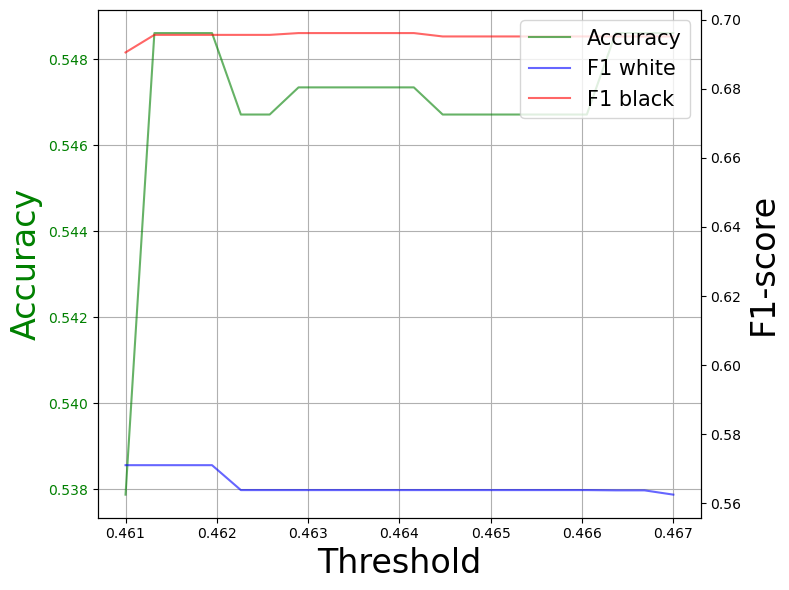

In [244]:
import matplotlib.pyplot as plt

# Your DataFrame plot_df
# Assuming plot_df contains columns: 'thresh', 'acc', 'net_pres_male', 'net_pres_female'

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase the figure size

# Plotting accuracy on the left y-axis
color = 'green'
ax1.set_xlabel('Threshold', fontsize=24)
ax1.set_ylabel('Accuracy', color=color, fontsize=24)
ax1.plot(plot_df['thresh'], plot_df['acc'], label='Accuracy', color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for precision
ax2 = ax1.twinx()

# Plotting precision on the right y-axis
#color = 'red'
ax2.set_ylabel('F1-score', fontsize=24)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_0)], label='F1 '+str(sensitive_value_0), color='blue', alpha=0.6)
ax2.plot(plot_df['thresh'], plot_df['F1_'+str(sensitive_value_1)], label='F1 '+str(sensitive_value_1), color='red', alpha=0.6)
ax2.tick_params(axis='y')

# Title and legend
#plt.title('Accuracy and F1-score vs Threshold', fontsize=15)

# Adjusting legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=15)

# Grid
ax1.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

In [245]:
#######INCOME########
#threshh = 0.455
#######INCOME########

#######COMPAS########

#######COMPAS########
#(model_name,model) = loaded_models[8]
(model_name,model) = loaded_models[model_idx]

outputs = model.evaluate(model.to_backend(x_scaled))
predictions = (outputs >= 0.456)
true = y

In [246]:
############  FOR INCOME  #############
df_out = pd.DataFrame(np.array(x_raw), columns=out_columns)
df_out["pred_labels"] = np.array(predictions).astype(int)
df_out["true_labels"] = np.array(true).astype(int)

In [247]:
# ############ FOR COMPAS ############
# df_out = pd.DataFrame(np.array(x_raw), columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code', 'two_year_recid'])
# df_out["pred_labels"] = np.array(predictions).astype(int)
# df_out["true_labels"] = np.array(true).astype(int)

In [248]:
acc = len(df_out[df_out["true_labels"] == df_out["pred_labels"]])/len(df_out)
print(acc)

0.5347222222222222


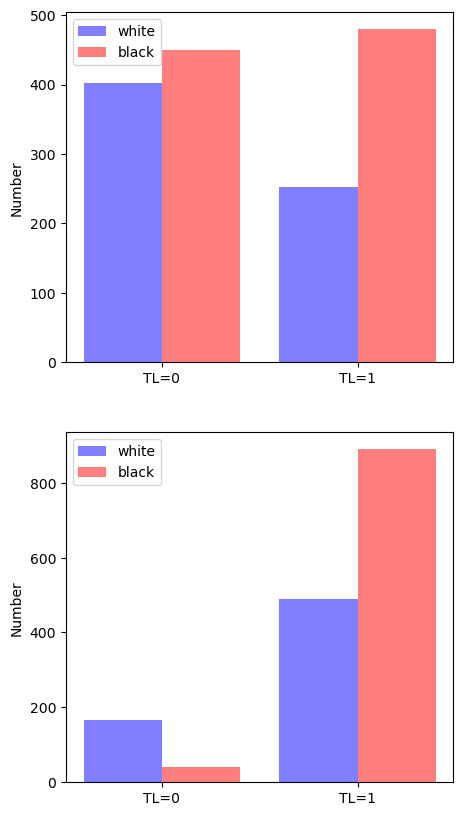

In [249]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = [category_0, category_1]
values1 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["true_labels"] == 1)])]
values2 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["true_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
#ax[0].set_title("Distribution of True labels across "+ str(sensitive))
ax[0].legend()


categories2 = [category_0, category_1]
values3 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_0) & (df_out["pred_labels"] == 1)])]
values4 = [len(df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 0)]), len(
    df_out[(df_out[sensitive_col_name] == SENSITIVE_CODE_1) & (df_out["pred_labels"] == 1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label=sensitive_value_0, alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label=sensitive_value_1, alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
#ax[1].set_title("Distribution of Predicted labels across "+str(sensitive))
ax[1].legend()

In [250]:
tp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fp_sensitive_1 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
tn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])
fn_sensitive_1 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_1)])

tp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fp_sensitive_0 = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
tn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])
fn_sensitive_0 = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out[sensitive_col_name] == SENSITIVE_CODE_0)])

In [251]:
fpr_sensitive_1 = fp_sensitive_1/(fp_sensitive_1 + tn_sensitive_1)
tpr_sensitive_1 = tp_sensitive_1/(tp_sensitive_1 + fn_sensitive_1)
fpr_sensitive_0 = fp_sensitive_0/(fp_sensitive_0 + tn_sensitive_0)
tpr_sensitive_0 = tp_sensitive_0/(tp_sensitive_0 + fn_sensitive_0)

fnr_sensitive_1 = fn_sensitive_1/(fn_sensitive_1 + tp_sensitive_1)
tnr_sensitive_1 = tn_sensitive_1/(tn_sensitive_1 + fp_sensitive_1)
fnr_sensitive_0 = fn_sensitive_0/(fn_sensitive_0 + tp_sensitive_0)
tnr_sensitive_0 = tn_sensitive_0/(tn_sensitive_0 + fp_sensitive_0)

Various rates achieved with the particular model selection (values directly taken from a general unconstrained optimizion problem (Adam for ex))

In [252]:
if DATASET == 'compas':
    values1 = [0.41, 0.15, 0.85, 0.58]
    values2 = [0.64, 0.32, 0.66, 0.34]
elif DATASET == 'income':
    values1 = [0.48, 0.08, 0.65, 0.32]
    values2 = [0.28, 0.01, 0.41, 0.14]

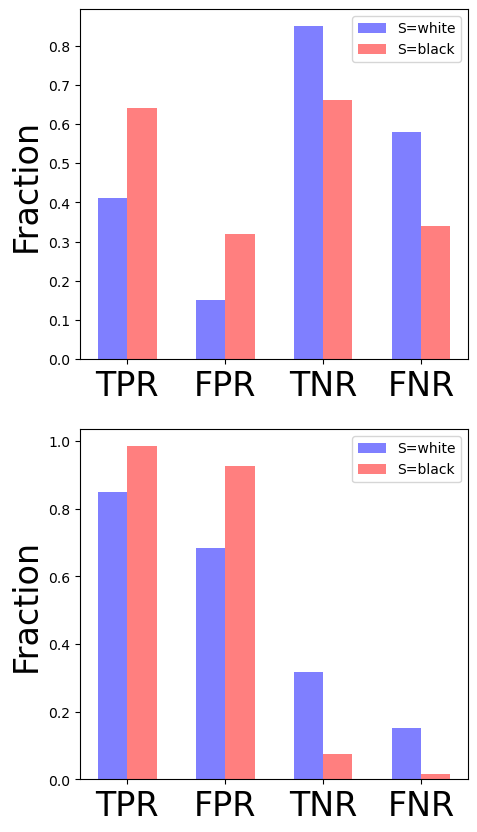

In [253]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['TPR', 'FPR', 'TNR', 'FNR']
# values1 = [0.41, 0.15, 0.85, 0.58]
# values2 = [0.64, 0.32, 0.66, 0.34]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1, fontsize=24)

# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Fraction", fontsize=24)
#ax[0].set_title('Performance metrics without constraints')
ax[0].legend()


categories2 = ['TPR', 'FPR', 'TNR', 'FNR']
values3 = [tpr_sensitive_0, fpr_sensitive_0, tnr_sensitive_0, fnr_sensitive_0]
values4 = [tpr_sensitive_1, fpr_sensitive_1, tnr_sensitive_1, fnr_sensitive_1]

bar_width = 0.3  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
          label='S='+str(sensitive_value_0), alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
          width=bar_width, label='S='+str(sensitive_value_1), alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2, fontsize=24)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Fraction", fontsize=24)
#ax[1].set_title('Performance metrics with constraints')
ax[1].legend()


In [254]:
import numpy as np
import matplotlib.pyplot as plt


# Function to plot y = sin(x - value_slider)
def plot_sin(shift):
    x = np.linspace(0, np.pi * 2, 1000)
    y = np.sin(x - shift)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('sin(x - shift)')
    plt.title('Plot of y = sin(x - shift)')
    plt.grid(True)
    plt.show()

# Create slider for selecting the shift value
shift_slider = FloatSlider(value=0, min=0, max=np.pi/2, step=0.01, description='Shift:')
# Create button for generating the plot
generate_button = Button(description='Generate')

# Output widget to display the plot
output = Output()

# Function to handle button click event
def on_button_click(button):
    with output:
        output.clear_output()
        plot_sin(shift_slider.value)

# Registering the button click event
generate_button.on_click(on_button_click)

# Arrange widgets
vbox = VBox([shift_slider, generate_button, output])
vbox